# Assessment of Operating Envelopes to Orchestrate DERs
# OE Algorithm 3: Asset Capacity & Critical Voltage

## 1. Introduction

This work is part of the project [Assessing the Benefits of Using Operating Envelopes to Orchestrate DERs Across Australia](https://electrical.eng.unimelb.edu.au/power-energy/projects/assessing-the-benefits-of-OEs-across-Australia) funded by CSIRO. This project provided key metrics and recommendations for distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) and AEMO (the Australian system operator) to assist them in their decision-making process when defining the most suitable Operating Envelope (OE) implementations in a given distribution area.

> <span style="color:purple">**What are Operating Envelopes (OEs)?** OEs are time-varying export or import limits calculated in real time or in advance at the connection point of the customer to ensure the integrity of the distribution network (i.e., customer voltages within limits and no asset congestion). The OEs are calculated only for customers with flexible connection agreements (called here *active customers*). Customers with conventional connection agreements (called here *passive customers*) do not require OEs.</span>

**This interactive notebook demonstrates the process to implement the *Asset Capacity & Critical Voltage OE Algorithm*** produced by The University of Melbourne. This demonstration is useful for different stakeholders (e.g., DNSPs, AEMO, CSIRO, regulators, consultancy companies, technology providers) as it can help them familiarise with the corresponding algorithm and the required inputs as well as the pros and cons.

> <span style="color:purple">The **Asset Capacity & Critical Voltage (AC_CrV) OE** is more advanced than the Asset Capacity OE as both voltage and thermal aspects are considered instead of only thermal. Thermal aspects are considered by calculating the spare capacity of the distribution transformer, while voltage aspects are considered by estimating the voltage at the critical customer via a P-V sensitivity curve.</span>
> - Monitoring: At the secondary of the transformer (aggregated P and aggregated Q per phase), and at the critical customer (voltage magnitude and net demand P).
> - Electrical models needed: None.

## 2. Algorithm Overview  
The **AC_CrV OE** requires a P-V sensitivity curve that is used to estimate the voltage at the critical customer from its net active power demand. This P-V sensitivity curve can be obtained beforehand with historical data from the critical customer, and it can be used for every time step since the sensitivity curve is unlikely to change within short time periods. To obtain this P-V sensitivity curve:
- Take the historical net active power demand and voltages of the critical customer for a given period (e.g., two days), and use them as input to a polynomial fit function from a standard library (e.g., Python NumPy).

Once the required sensitivity curve is available, the AC_CrV OE algorithm has two main steps. First, the spare capacity of the distribution transformer is split among active customers (temporary OE value). Second, the P-V sensitivity curve for the critical customer is used to estimate its voltage according to the temporary OE value. If the voltage is beyond the limit, the temporary OE value is reduced and the voltage re-estimated and re-assessed. This repeats until no voltage problem is expected. Furthermore, for calculations in advance (e.g., hours ahead), forecasting capabilities are also needed (however, here, perfect forecasting is used for simplicity).

For a given point in time (e.g., at 12:00PM), the high-level steps of the algorithm are as follows:
1. **Obtain forecasted aggregated passive customer net demand**. This value is obtained by subtracting the forecasted aggregated active customer net demand from the forecasted distribution transformer demand (which includes all customers). Note that sign convention and direction of power flows have to be adequately considered since one can be importing and the other exporting power depending on the time of the day. 
2. **Calculate the spare capacity of the distribution transformer for OE exports (or OE imports)**. This value is obtained by subtracting the aggregated passive customer net demand forecast from the rated capacity of the transformer. It forms the basis to calculate OE exports (or OE imports). Note that sign convention and direction of power flows have to be adequately considered as the spare capacity will be different for exports and imports.
3. **Check if spare capacity is available for OE exports (or OE imports)**. If there is spare capacity available, proceed to step 4 to split the spare capacity. Otherwise, the calculated OE value to all active customers is equal to zero, thus proceed to step 7.
4. **Allocate the spare capacity for OE exports (or OE imports)**. Divide the spare capacity among all active customers, proportionally, considering the corresponding DER sizes. The allocated spare capacity to each active customer is a temporary OE value (P').
5. **Estimate the voltage at the critical customer for OE exports (or OE imports)**. Use the temporary OE value (P') for the critical customer and the P-V sensitivity curve to estimate the voltage magnitude (V') at this customer.
6. **Check for voltage problems at the critical customer for OE exports (or OE imports)**. If the estimated voltage at the critical customer breaches the network limit, reduce the temporary OE value (P') of the critical customer by a pre-defined value (e.g., 1kW), and go back to step 5. Otherwise, the temporary OE value P' corresponds to the OE exports (or imports) for each active customer, thus proceed to step 7.
7. **Move to the next time step (e.g., 12:05PM) and restart the process from step 1.**

<span style="color:red">**<u>Note 1</u>.</span>** The OE exports and OE imports are calculated separately. When calculating exports, all active customers are considered to export. When calculating imports, all active customers are considered to import. This ensures the asset integrity even if all active customers operate at their maximum allocated OE capacity (worst case scenario).

<span style="color:red">**<u>Note 2</u>.</span>** For simplicity, in step 1, only the active power demand (P) was considered for the forecasted aggregated active customer net demand. However, if the reactive power demand (Q) is available (as it is the case for most monitoring devices), then it should be considered in the calculations.

<span style="color:red">**<u>Note 3</u>.</span>** The forecasted aggregated passive customer net demand in step 1 can also be obtained in other ways. For instance, if the DNSP has 100% smart meter penetration and forecast for all customers, the net demand of passive customers can be simply summed.

<span style="color:red">**<u>Note 4</u>.</span>** Network losses are not being considered here, but it should be simple to add to the algorithm.

<span style="color:red">**<u>Note 5</u>.</span>** For OE calculations in real-time no forecast is needed, real-time measurements from the network/customers should be used instead.

<span style="color:red">**<u>Note 6</u>.</span>** Only the proportional allocation can be done for the AC_CrV OE since other allocation techniques usually require knowledge of voltages in all customers.

<span style="color:red">**<u>Note 7</u>.</span>** The OE values are calculated for the active power only. The reactive power of PV systems are considered to be zero all the time.

<span style="color:red">**<u>Note 8</u>.</span>** The OE was not constrained by the LV head of feeder because it was considered the simplest possible algorithm to avoid needing extra data, but it can be easily added if data from individual LV feeders are available.

## 3. Inputs and Outputs for the OE Calculation Algorithm
### Time-Varying Inputs
- Historical voltage magnitude of the critical active customer in the LV network.
- Historical net active power demand of the critical active customer in the LV network.
- Forecasted aggregated active customer net demand (P).
- Forecasted distribution transformer demand (P, Q).

### Static Inputs
- Rated capacity of the distribution transformer.
- Number of active customers.
- DER size of active customers.

### Outputs
- The OEs for exports and imports. 

## 4. Test LV Network
To demonstrate the OE algorithm, the realistic Test LV network shown in Figure 1 is used. This network has the following characteristics:
- Three 3-phase LV feeders.
- 114 single-phase residential customers connected via service cables. 
- 16 (out of 114) are active customers (around 15%).
- 98 (out of 114) are passive customers.
- 35 of passive customers have PV systems (a PV penetration of 30% for the whole LV network).
- The PV systems have the same installed capacity of 5kVA. They also have the combined Volt-Watt and Volt-Var functions enabled.
- All active customers have the same DER installed capacity of 10kVA (e.g., PV + battery).

<span style="color:red">**<u>Note</u>.</span>** For simplicity, the case study used to demonstrate the OE algorithm corresponds to a low voltage (LV) network without modelling the upstream high voltage (HV) network. Although some adaptations have been made to ensure realistic voltage fluctuations at the distribution transformer of the LV network, the results are not exactly the same as those presented in the Final Report of the project (which used an integrated HV-LV network model). Nevertheless, the behaviour of the OE algorithm and the qualitative nature of the results remain the same. The following adaptions were made:
- The voltage variation along the day caused by the HV part is modelled as a voltage source (following the values taken from the full HV-LV model).
- To better represent the voltage rise/drop at the primary side of the distribution transformer (due to OE exports/imports), a fictitious line is created between the voltage source and the distribution transformer.

<img style="float: middle;" src="LV_Network.SVG" width="100%">  

**<center>Figure 1. Test LV Network</center>**   

## 5. interactive Code
<span style="color:red">**<u>Note</u>.</span>** This interactive notebook is designed to facilitate the learning/teaching of the content. Therefore, the definitions of functions are not made at the beginning of the notebook as it is usually done when just coding.
### 5.1. Initialisation of Libraries

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import dss

### 5.2. Load/Prepare Necessary Inputs
Load the necessary inputs to calculate the Asset Capacity & Critical Voltage OE.

In [2]:
# Load the list of active customers from the database
mydir = os.getcwd()
names_active_cust = np.load(mydir + '/Simulation_Files/active_cust_30-15.npy') 

# Assumed size of active customers' DERs is 10kW (PV + battery)
# In reality, this info would come from the database 
active_cust_der_size = np.ones(len(names_active_cust)) * 10 

# Known rated capaciy of the distribution transformer in kVA
# This info would come from the database
tx_rated_capacity = 500 

# Load the historical voltage magnitude of the critical active customer in the LV network
# NB. Critical customer chosen by its distance from the distirbution transformer
hist_voltage_crit_cust = np.load(mydir + '/Simulation_Files/AC_CrV_OE_V_crit_cust.npy') # 2 days of data

# Load the historical net active power demand of the critical active customer in the LV network
# NB. Critical customer chosen by its distance from the distirbution transformer
hist_net_demand_crit_cust = np.load(mydir + '/Simulation_Files/AC_CrV_OE_P_crit_cust.npy') # 2 days of data

# load the forecasted aggregated active customer net demand
# sign convention: positive = exporting power; negative = importing power
forecast_agg_net_p_act_cust = np.load(mydir + '/Simulation_Files/ac_oe_agg_p_act_cust.npy') 

# load the forecasted distribution transformer active (P) and reactive (Q) power demand
# sign convention: positive = exporting power; negative = importing power
forecast_p_tx = np.load(mydir + '/Simulation_Files/ac_oe_p_tx.npy') # active power
forecast_q_tx = np.load(mydir + '/Simulation_Files/ac_oe_q_tx.npy') # reactive power

# Calculate the forecasted distribution transformer demand (apparent power, S)
forecast_s_tx = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    forecast_s_tx[i] = np.sqrt(forecast_p_tx[i]**2 + forecast_q_tx[i]**2)

# Calculate the forecasted aggregated passive customer net demand
# note that this calculation is not generalised and should be adapted for other data sets
forecast_agg_net_p_passive_cust = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_p_tx[i] < 0 and forecast_agg_net_p_act_cust[i] < 0: 
        forecast_agg_net_p_passive_cust[i] = -1 * (forecast_s_tx[i] - abs(forecast_agg_net_p_act_cust[i]))
    if forecast_p_tx[i] > 0 and forecast_agg_net_p_act_cust[i] < 0: 
        forecast_agg_net_p_passive_cust[i] = forecast_s_tx[i] + abs(forecast_agg_net_p_act_cust[i])

# Calculate the spare capacity of the distribution transformer for exports     
forecast_spare_capacity_exp = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_agg_net_p_passive_cust[i] < 0:
        forecast_spare_capacity_exp[i] = tx_rated_capacity + abs(forecast_agg_net_p_passive_cust[i])
    if forecast_agg_net_p_passive_cust[i] > 0:
        forecast_spare_capacity_exp[i] = tx_rated_capacity - abs(forecast_agg_net_p_passive_cust[i])

# Calculate the spare capacity of the distribution transformer for imports
forecast_spare_capacity_imp = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_agg_net_p_passive_cust[i] < 0:
        forecast_spare_capacity_imp[i] = tx_rated_capacity - abs(forecast_agg_net_p_passive_cust[i])
    if forecast_agg_net_p_passive_cust[i] > 0:
        forecast_spare_capacity_imp[i] = tx_rated_capacity + abs(forecast_agg_net_p_passive_cust[i])

### 5.3. Create Functions for the Asset Capacity & Critical Voltage OE Algorithms
#### P-V Sensitivity Curve

In [3]:
# use the historical data from the critical customer in a polynomial fit function from a standard 
# library (e.g., Python NumPy) to create the P-V sensitivity curve
p_v_sensit_curve = np.poly1d(np.polyfit(hist_net_demand_crit_cust, hist_voltage_crit_cust, 1))

Create a figure to show the P-V sensitivty curve.

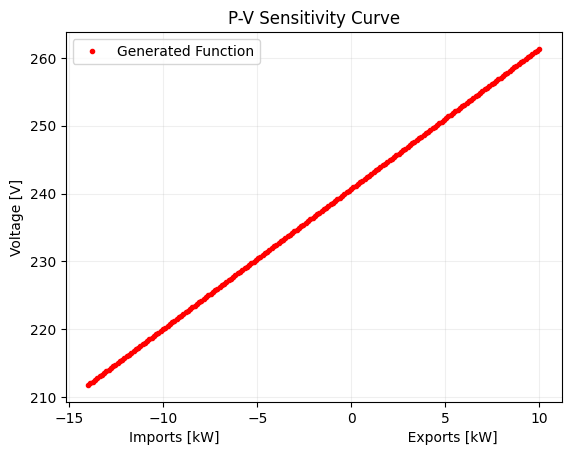

In [4]:
plt.figure()
p_tx_temp = np.linspace(-14,10,200)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], p_v_sensit_curve(p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], p_v_sensit_curve(p_tx_temp[i]), '.', color='red')
plt.title('P-V Sensitivity Curve')
plt.xlabel('Imports [kW]                                           Exports [kW]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

#### OEs for Exports

In [5]:
def ac_crv_oe_exp_algorithm(
    names_active_cust,
    tx_spare_capacity_exp,
    active_cust_der_size,
    p_v_sensit_curve
):
    """
    Function to calculate the Asset Capacity & Critical Voltage OE proportional allocation for exports in each time step.
    This is used in all time steps of the day.    
    :param names_active_cust: the list of active customers 
    :param tx_spare_capacity_exp: the distribution transformer spare export capacity of the considered time step
    :param active_cust_der_size: the size of active customers' DERs 
    :param p_v_sensit_curve: the P-V sensitivity curve of the critical customer
    :return ac_crv_oe_exp_values: the calculated AC_CrV OE value for proportional allocation and exports
    """
    
    # First main step: the capacity of the distribution transformer together with its time-varying input data 
    # is used to calculate its spare capacity
    alloc_exp_p_temp = np.zeros(len(names_active_cust), float) # initialisation of the operating envelope value 
    
    # check if there is spare capacity on the distribution transformer, if positive there is spare capacity,
    # if negative or zero the allocated operating envelope is equal to zero (same value as initialisation)
    if tx_spare_capacity_exp > 0: 
        tx_spare_capacity_temp = tx_spare_capacity_exp # copy the spare capacity to a temporary variable
        
        # run this until there is no more spare capacity or the maximum possible OE value (defined by connection agreement,
        # or fuse of the house) was achieved to all active customers
        while tx_spare_capacity_temp > 0: 
            for ild in range(len(names_active_cust)): # iterate through all active customers to calculate the OE value
                
                # Proportionally allocate spare capacity of the distribution transformer to each active customer
                alloc_exp_p_temp[ild] += tx_spare_capacity_temp * active_cust_der_size[ild] / sum(active_cust_der_size) 
                
                # Check is the allocated spare capacity pass the maximum possible OE value and cap it if needed
                if alloc_exp_p_temp[ild] > 10:  # Usually maximum injection allowed by DNSPs per phase (10kW)
                    alloc_exp_p_temp[ild] = 10
            
            # check if the maximum possible OE value (10kW) was achieved to all acticve customers
            if (alloc_exp_p_temp == 10).all():
                break # the maximum possible OE value (10kW) was achieved to all acticve customers
            else:
                
                # there are still some active customers below the maximum possible OE value 
                # check if there is still some spare capacity to be allocated
                tx_spare_capacity_temp = tx_spare_capacity_exp - sum(alloc_exp_p_temp) 

                
        # Second main step: the P-V sensitivity curve for the critical customer is used to estimate its voltage
        flag = 0 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
        
        # select the expected active power export for the critical customer, which is to use the full 
        # allocation of spare capacity made above 
        expected_pnet_crit_cust = alloc_exp_p_temp[12] # 12 is the location of the critical customer in the array
        
        # run the loop until no voltage problem is expected
        while flag == 0:
            
            # use the P-V sensitivity curve to estimate the voltage at the critical customer for the expected 
            # active power export
            expected_v_crit_cust = p_v_sensit_curve(expected_pnet_crit_cust)
            
            # check if the expected voltage at the critical customer is above 253V  
            if expected_v_crit_cust > 253:
                expected_pnet_crit_cust -= 0.5 # if above the limit, reduce the allocated OE by 0.5kW (pre-defined reduction step)
                
                # check if the OE has achieved the minimum possible OE value (zero)
                if expected_pnet_crit_cust < 0: 
                    expected_pnet_crit_cust = 0 # if below zero, allocate zero as OE value
                    
                    # voltage problems are still expected even after OE value is equal to zero. OE calculation finished.
                    break
            else:
                flag = 1 # no voltage problems are expected. OE calculation finished.
    ac_crv_oe_exp_values = expected_pnet_crit_cust # rename the allocated OE value
    
    return ac_crv_oe_exp_values # return the calculated OE value for the export for the considered time step

#### OEs for Imports

In [6]:
def ac_crv_oe_imp_algorithm(
    names_active_cust,
    tx_spare_capacity_imp,
    active_cust_der_size,
    p_v_sensit_curve
):
    """
    Function to calculate the Asset Capacity & Critical Voltage OE proportional allocation for imports in each time step.
    This is used in all time steps of the day.
    :param names_active_cust: the list of active customers 
    :param tx_spare_capacity_imp: the distribution transformer spare import capacity of the considered time step
    :param active_cust_der_size: the size of active customers' DERs 
    :param p_v_sensit_curve: the P-V sensitivity curve of the critical customer
    :return ac_crv_oe_imp_values: the calculated AC_CrV OE value for proportional allocation and imports
    """
    
    # First main step: the capacity of the distribution transformer together with its time-varying input data 
    # is used to calculate its spare capacity
    alloc_imp_p_temp = np.zeros(len(names_active_cust), float) # initialisation of the operating envelope value 
    
    # check if there is spare capacity on the distribution transformer, if positive there is spare capacity,
    # if negative or zero the allocated operating envelope is equal to zero (same value as initialisation)
    if tx_spare_capacity_imp > 0: 
        tx_spare_capacity_temp = tx_spare_capacity_imp # copy the spare capacity to a temporary variable
        
        # run this until there is no more spare capacity or the maximum possible OE value (defined by connection agreement,
        # or fuse of the house) was achieved to all active customers
        while tx_spare_capacity_temp > 0:
            for ild in range(len(names_active_cust)): # iterate through all active customers to calculate the OE value
                
                # Proportionally allocate spare capacity of the distribution transformer to each active customer
                alloc_imp_p_temp[ild] += tx_spare_capacity_temp * active_cust_der_size[ild] / sum(active_cust_der_size) # Proportionally allocate spare capacity of the distribution transformer to active customers (power factor equal to 1)
                
                # Check is the allocated spare capacity pass the maximum possible OE value and cap it if needed
                if alloc_imp_p_temp[ild] > 14: # Limited by a single-phase fuse of 60A (14kW)
                    alloc_imp_p_temp[ild] = 14 
            
            # check if the maximum possible OE value (14kW) was achieved to all acticve customers
            if (alloc_imp_p_temp == 14).all():
                break # the maximum possible OE value (14kW) was achieved to all acticve customers
            else:
                
                # there are still some active customers below the maximum possible OE value 
                # check if there is still some spare capacity to be allocated
                tx_spare_capacity_temp = tx_spare_capacity_imp - sum(alloc_imp_p_temp)
        
        
        # Second main step: the P-V sensitivity curve for the critical customer is used to estimate its voltage
        flag = 0 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
        
        # select the expected active power import for the critical customer, which is to use the full 
        # allocation of spare capacity made above 
        expected_pnet_crit_cust = -1 * alloc_imp_p_temp[12] # 12 is the location of the critical customer in the array
        
        # run the loop until no voltage problem is expected
        while flag == 0:
            
            # use the P-V sensitivity curve to estimate the voltage at the critical customer for the expected 
            # active power import
            expected_v_crit_cust = p_v_sensit_curve(expected_pnet_crit_cust)
            
            # check if the expected voltage at the critical customer is below 216V  
            if expected_v_crit_cust < 216:
                
                # if above the limit, reduce the allocated OE by 0.5kW (pre-defined reduction step)
                # since the "expected_pnet_crit_cust" is negative the 0.5kW is summed to it
                expected_pnet_crit_cust += 0.5 
                
                # check if the OE has achieved the minimum possible OE value (zero)
                if expected_pnet_crit_cust > 0: 
                    expected_pnet_crit_cust = 0 # if below zero, allocate zero as OE value
                    
                    # voltage problems are still expected even after OE value is equal to zero. OE calculation finished.
                    break 
            else:
                flag = 1 # no voltage problems are expected, so OE calculation finished    
    ac_crv_oe_imp_values = expected_pnet_crit_cust # rename the allocated OE value
    
    return ac_crv_oe_imp_values # return the calculated OE value for the import for the considered time step

### 5.4. Run the Asset Capacity & Critical Voltage OE Algorithm for the Day

In [7]:
# define number of time steps in the day (24h) for the corresponding time resolution
num_of_time_step = 288

# initialise arrays to save the OE values for each time step of the day
ac_crv_oe_day_exp_values = np.zeros((len(names_active_cust), num_of_time_step), float) # for exports
ac_crv_oe_day_imp_values = np.zeros((len(names_active_cust), num_of_time_step), float) # for imports

# Calculate the OE values for each time step of the day in a for loop
for itime in range(num_of_time_step):
    tx_spare_capacity_exp = forecast_spare_capacity_exp[itime] # separate the transformer export capacity for the current time step
    tx_spare_capacity_imp = forecast_spare_capacity_imp[itime] # separate the transformer import capacity for the current time step
    
    # call the AC CrV OE functions to calculate the OE value to each time step
    ac_crv_oe_day_exp_values[:,itime] = ac_crv_oe_exp_algorithm(names_active_cust, tx_spare_capacity_exp, active_cust_der_size, p_v_sensit_curve) # export
    ac_crv_oe_day_imp_values[:,itime] = ac_crv_oe_imp_algorithm(names_active_cust, tx_spare_capacity_imp, active_cust_der_size, p_v_sensit_curve) # import

Create a figure to show the calculated OE values (exports/imports) for the entire day.

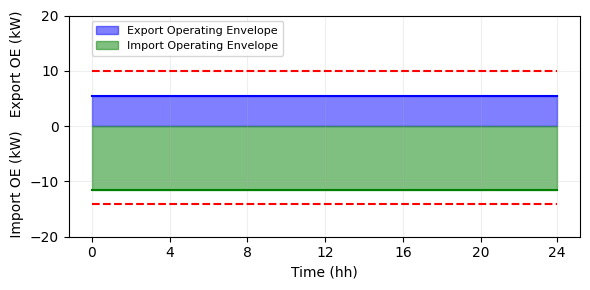

In [8]:
# plot the calculated oeprating envelopes
x = range(num_of_time_step)
y1 = ac_crv_oe_day_exp_values
y2 = ac_crv_oe_day_imp_values
y3 = np.ones(num_of_time_step) * 10
y4 = np.ones(num_of_time_step) * -14

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel(" Import OE (kW)   Export OE (kW)")
plt.xlabel("Time (hh)")
plt.fill_between(x, y1[12], color="blue", alpha=0.5, label='Export Operating Envelope')
plt.plot(x, y1[12], color="blue", alpha=1)
plt.fill_between(x, y2[12], color="green", alpha=0.5, label='Import Operating Envelope')
plt.plot(x, y2[12], color="green", alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y4, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(-20, 20)
plt.legend(loc='upper right', fontsize=8, bbox_to_anchor=(0, 0, 0.43, 1))
plt.tight_layout()
plt.show()


Given that all active customers have the same DER installed capacity (10kVA), the calculated OEs (shown in the figure above) is the same for all active customers. It is important to note that:
- Because only one customer is used as reference to estimate voltages, the OEs for exports and imports are constant in time.
- The OEs for exports is always in 5.5kW as it corresponds to the maximum voltage limit of 253V in the P-V senstivity curve.
- The OEs for imports is always in 11.5kW as it corresponds to the minimum voltage limit of 216V in the P-V sensitivity curve.

### 5.5. Perfomance Check
Now the efficacy of the calculated OEs is checked using the Test LV Networks.

<span style="color:red">**<u>Note</u>.</span>** All active customers are assumed to be using the full available OE value calculated for them.

In [9]:
# initialise the OpenDSS to run the network
dss_engine = dss.DSS
dss_text = dss_engine.Text                                                      
dss_circuit = dss_engine.ActiveCircuit                                            
dss_solution = dss_engine.ActiveCircuit.Solution                                      
control_queue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

# define time resolution of the data
time_resolution = 5 # in minutes

# load the entire LV network with transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation
dss_text.Command = 'Clear'
dss_text.Command = 'Compile ' + mydir + '/Simulation_Files/Master.txt' 
dss_text.Command = 'Set VoltageBases=[22.0, 0.400, 0.2309]'
dss_text.Command = 'calcv'
dss_text.Command = 'Set ControlMode=static'
dss_text.Command = 'Reset'                                                     
dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

# load voltage magnitudes and angles at the primary side of the distribution transformer which are affected by the 
# interactions with the upstream HV network (collected in another platform where the HV-LV network is fully modelled)
tx_pri_voltages_day = np.load(mydir + '/Simulation_Files/tx_pri_voltages_day_30-15.npy') # voltage magnitudes
tx_pri_angles_day = np.load(mydir + '/Simulation_Files/tx_pri_angles_day_30-15.npy') # voltage angles

# load LV network data from the OpenDSS model
load_list = dss_circuit.Loads.AllNames # list of loads
line_list = dss_circuit.Lines.AllNames # list of lines

# initialisation of arrays/lists to save simulation data
valid_exp_voltage_lv_cust = np.zeros((len(load_list), num_of_time_step), float)
valid_imp_voltage_lv_cust = np.zeros((len(load_list), num_of_time_step), float)
valid_exp_max_lv_hof_util  = []
valid_imp_max_lv_hof_util  = []
valid_exp_lv_tx_util  = []
valid_imp_lv_tx_util  = []



# Test for OE Export
# implement the calculated OE value or each time step of the day in a for loop and check for technical compliance
for itime in range(num_of_time_step):
    # Set vsource with the distribution transformer voltage magnitudes and angles for the time step at the primary side
    temp1 = tx_pri_voltages_day[0][itime] / (22000 / np.sqrt(3))
    temp2 = tx_pri_angles_day[0][itime]
    temp3 = tx_pri_voltages_day[1][itime] / (22000 / np.sqrt(3))
    temp4 = tx_pri_angles_day[1][itime]
    temp5 = tx_pri_voltages_day[2][itime] / (22000 / np.sqrt(3))
    temp6 = tx_pri_angles_day[2][itime]
    dss_text.Command = 'edit vsource.source bus1=sourcebus.1 basekv=12.701706 pu='+str(temp1)+' angle='+str(temp2)+' phases=1'
    dss_text.Command = 'edit vsource.source2 bus1=sourcebus.2 basekv=12.701706 pu='+str(temp3)+' angle='+str(temp4)+' phases=1'    
    dss_text.Command = 'edit vsource.source3 bus1=sourcebus.3 basekv=12.701706 pu='+str(temp5)+' angle='+str(temp6)+' phases=1'    
    
    
    dss_solution.Solve()
 
    
    # implement the calculated OE value to each active customer
    for ild in range(len(names_active_cust)):
        dss_circuit.SetActiveElement('load.' + str(names_active_cust[ild])) # select an active customer
        temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
        dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
        dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * ac_crv_oe_day_exp_values[ild, itime]) # set the kW to the calculated OE value
        dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before    
    
    dss_solution.SolveSnap() # solve the power flow for the time step with OE values in place

    # verify thermal limits of lines
    for iline in range(len(line_list)):
        dss_circuit.SetActiveElement('line.' + str(line_list[iline])) # select a line
        I11 = dss_circuit.ActiveCktElement.CurrentsMagAng[0] # extract the current at the corresponding line (phase A)
        I12 = dss_circuit.ActiveCktElement.CurrentsMagAng[2] # extract the current at the corresponding line (phase B)
        I13 = dss_circuit.ActiveCktElement.CurrentsMagAng[4] # extract the current at the corresponding line (phase C)
        I_rated = dss_circuit.Lines.NormAmps # extract rated capacity of the corresponding line
        I_max_temp = max(I11, I12, I13) # find the maximum current among the three phases
        if line_list[iline] == 'hv_f0_lv28_f0_l0':
            lv_hof_util_f0 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 1, calculate the utilisation
        if line_list[iline] == 'hv_f0_lv28_f1_l0':
            lv_hof_util_f1 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 2, calculate the utilisation
        if line_list[iline] == 'hv_f0_lv28_f2_l0':
            lv_hof_util_f2 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 3, calculate the utilisation
    lv_hof_util_max = max(lv_hof_util_f0, lv_hof_util_f1, lv_hof_util_f2) # find the maximum utilisation at the HoF
    
    # verify thermal limits of transformer
    dss_circuit.SetActiveElement('transformer.hv_f0_lv28_tx') # select the distribution transformer
    dss_circuit.Transformers.Wdg = 2 # select secondary winding (LV side)
    tx_rated_volt_sec = dss_circuit.Transformers.kV / np.sqrt(3) # Extract the transformer rated voltage at the secondary side
    tx_amp_capacity_phase = (float(dss_circuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0]) / 3) / tx_rated_volt_sec # extract the capacity in amps per phase
    I1_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[8] # extract the current at the corresponding transformer (phase A)
    I2_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[10] # extract the current at the corresponding transformer (phase B)
    I3_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[12] # extract the current at the corresponding transformer (phase C)
    lv_tx_util = 100 * (I1_LVT_temp + I2_LVT_temp + I3_LVT_temp) / (3 * tx_amp_capacity_phase) # find the maximum utilisation at the transformer
        
    # verify voltages in all customers
    all_volt_temp = [] # initialise array to collect the voltages
    for ild in range(len(load_list)):
        dss_circuit.SetActiveElement('load.' + str(load_list[ild])) # select the customer
        temp = dss_circuit.ActiveElement.VoltagesMagAng # extract the voltage magnitude
        all_volt_temp.append(temp[0]) # add the voltage to the array 
            
    valid_exp_voltage_lv_cust[:, itime] = all_volt_temp # save voltages from all customers for the current time step 
    valid_exp_max_lv_hof_util.append(lv_hof_util_max) # save the maximum utilisation of the LV HoF for the current time step
    valid_exp_lv_tx_util.append(lv_tx_util) # save the transformer utilisation for the current time step


    # Reset active customers to original profile values for the next time step
    default_kw_kvar = 1
    for ild in range(len(names_active_cust)):
        dss_circuit.SetActiveElement('load.' + str(names_active_cust[ild]))
        dss_circuit.ActiveElement.Properties('status').Val = 'variable'
        dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
        dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)        
    
    
    
# Test for OE Import
# re-load the entire LV network with transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation
dss_text.Command = 'Clear'
dss_text.Command = 'Compile ' + mydir + '/Simulation_Files/Master.txt'
dss_text.Command = 'Set VoltageBases=[22.0, 0.400, 0.2309]'
dss_text.Command = 'calcv'
dss_text.Command = 'Set ControlMode=static'
dss_text.Command = 'Reset'                                                     
dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

# implement the calculated OE value or each time step of the day in a for loop and check for technical compliance
for itime in range(num_of_time_step):
    # Set vsource with the distribution transformer voltage magnitudes and angles for the time step at the primary side
    temp1 = tx_pri_voltages_day[0][itime] / (22000 / np.sqrt(3))
    temp2 = tx_pri_angles_day[0][itime]
    temp3 = tx_pri_voltages_day[1][itime] / (22000 / np.sqrt(3))
    temp4 = tx_pri_angles_day[1][itime]
    temp5 = tx_pri_voltages_day[2][itime] / (22000 / np.sqrt(3))
    temp6 = tx_pri_angles_day[2][itime]
    dss_text.Command = 'edit vsource.source bus1=sourcebus.1 basekv=12.701706 pu='+str(temp1)+' angle='+str(temp2)+' phases=1'
    dss_text.Command = 'edit vsource.source2 bus1=sourcebus.2 basekv=12.701706 pu='+str(temp3)+' angle='+str(temp4)+' phases=1'    
    dss_text.Command = 'edit vsource.source3 bus1=sourcebus.3 basekv=12.701706 pu='+str(temp5)+' angle='+str(temp6)+' phases=1'    
    
    
    dss_solution.Solve()    
    
    
    # implement the calculated OE value to each active customer 
    for ild in range(len(names_active_cust)):
        dss_circuit.SetActiveElement('load.' + str(names_active_cust[ild])) # select an active customer
        temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
        dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
        dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * ac_crv_oe_day_imp_values[ild, itime]) # set the kW to the calculated OE value
        dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before    
        
    dss_solution.SolveSnap() # solve the power flow for the time step with OE values in place

    # verify thermal limits of lines
    for iline in range(len(line_list)):
        dss_circuit.SetActiveElement('line.' + str(line_list[iline])) # select a line
        I11 = dss_circuit.ActiveCktElement.CurrentsMagAng[0] # extract the current at the corresponding line (phase A)
        I12 = dss_circuit.ActiveCktElement.CurrentsMagAng[2] # extract the current at the corresponding line (phase B)
        I13 = dss_circuit.ActiveCktElement.CurrentsMagAng[4] # extract the current at the corresponding line (phase c)
        I_rated = dss_circuit.Lines.NormAmps # extract rated capacity of the corresponding line
        I_max_temp = max(I11, I12, I13) # find the maximum current among the three phases
        if line_list[iline] == 'hv_f0_lv28_f0_l0':
            lv_hof_util_f0 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 1, calculate the utilisation
        if line_list[iline] == 'hv_f0_lv28_f1_l0':
            lv_hof_util_f1 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 2, calculate the utilisation
        if line_list[iline] == 'hv_f0_lv28_f2_l0':
            lv_hof_util_f2 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 3, calculate the utilisation
    lv_hof_util_max = max(lv_hof_util_f0, lv_hof_util_f1, lv_hof_util_f2) # find the maximum utilisation at the HoF
    
    # verify thermal limits of transformer
    dss_circuit.SetActiveElement('transformer.hv_f0_lv28_tx') # select the distribution transformer
    dss_circuit.Transformers.Wdg = 2 # select secondary winding (LV side)
    tx_rated_volt_sec = dss_circuit.Transformers.kV / np.sqrt(3) # Extract the transformer rated voltage at the secondary side
    tx_amp_capacity_phase = (float(dss_circuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0]) / 3) / tx_rated_volt_sec # extract the capacity in amps per phase
    I1_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[8] # extract the current at the corresponding transformer (phase A)
    I2_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[10] # extract the current at the corresponding transformer (phase B)
    I3_LVT_temp = dss_circuit.ActiveCktElement.CurrentsMagAng[12] # extract the current at the corresponding transformer (phase C)
    lv_tx_util = 100 * (I1_LVT_temp + I2_LVT_temp + I3_LVT_temp) / (3 * tx_amp_capacity_phase) # find the maximum utilisation at the transformer
        
    # verify voltages in all customers
    all_volt_temp = [] # initialise array to collect the voltages
    for ild in range(len(load_list)):
        dss_circuit.SetActiveElement('load.' + str(load_list[ild])) # select the customer
        temp = dss_circuit.ActiveElement.VoltagesMagAng # extract the voltage magnitude
        all_volt_temp.append(temp[0]) # add the voltage to the array 
     
    valid_imp_voltage_lv_cust[:, itime] = all_volt_temp # save voltages from all customers for the current time step 
    valid_imp_max_lv_hof_util.append(lv_hof_util_max) # save the maximum utilisation of the LV HoF for the current time step
    valid_imp_lv_tx_util.append(lv_tx_util) # save the transformer utilisation for the current time step
    
    
    # Reset active customers to original profile values for the next time step
    default_kw_kvar = 1
    for ild in range(len(names_active_cust)):
        dss_circuit.SetActiveElement('load.' + str(names_active_cust[ild]))
        dss_circuit.ActiveElement.Properties('status').Val = 'variable'
        dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
        dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)    

        
        
# Check network-wide voltage compliance
valid_exp_voltage_lv_cust_10min = np.zeros((len(load_list), 144), float)
valid_imp_voltage_lv_cust_10min = np.zeros((len(load_list), 144), float)
valid_exp_voltage_lv_cust_10min_sorted = np.zeros((len(load_list), 144), float)
valid_imp_voltage_lv_cust_10min_sorted = np.zeros((len(load_list), 144), float)
cont_exp = 0
cont_imp = 0
for ild in range(len(load_list)):
    for i in range(144):
        valid_exp_voltage_lv_cust_10min[ild,i] = (valid_exp_voltage_lv_cust[ild,2*i] + valid_exp_voltage_lv_cust[ild,2*i+1]) / 2
        valid_imp_voltage_lv_cust_10min[ild,i] = (valid_imp_voltage_lv_cust[ild,2*i] + valid_imp_voltage_lv_cust[ild,2*i+1]) / 2
    valid_exp_voltage_lv_cust_10min_sorted[ild,:] = np.sort(valid_exp_voltage_lv_cust_10min[ild,:])
    valid_imp_voltage_lv_cust_10min_sorted[ild,:] = np.sort(valid_imp_voltage_lv_cust_10min[ild,:])

    if (valid_exp_voltage_lv_cust_10min_sorted[ild,142] > 253) or (valid_exp_voltage_lv_cust_10min_sorted[ild,1] < 216):
        cont_exp += 1
    if (valid_imp_voltage_lv_cust_10min_sorted[ild,1] < 216) or (valid_imp_voltage_lv_cust_10min_sorted[ild,142] > 253):
        cont_imp += 1

exp_voltage_compliance = (1 - ((cont_exp) / len(load_list))) * 100
imp_voltage_compliance = (1 - ((cont_imp) / len(load_list))) * 100

Present various metrics showing the performance of the calculated OE export values for the considered day.


 EXPORTS

 The maximum voltage at customers: 253V (Right on the maximum voltage limit of 253V)

 The network-wide voltage compliance: 100% (Above the recommmended value of 95%)

 The maximum utilisation of the distribution transformer: 40% (Below the maximum utilisation of 100%)

 The maximum utilisation of the LV Head of Feeder: 6% (Below the maximum utilisation of 100%)


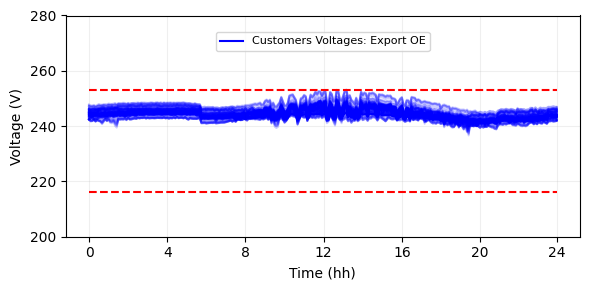

In [10]:
print('\n EXPORTS')
print('\n The maximum voltage at customers: {}V (Right on the maximum voltage limit of 253V)'.format(round(np.max(valid_exp_voltage_lv_cust))))
print('\n The network-wide voltage compliance: {}% (Above the recommmended value of 95%)'.format(round(exp_voltage_compliance)))
print('\n The maximum utilisation of the distribution transformer: {}% (Below the maximum utilisation of 100%)'.format(round(np.max(valid_exp_lv_tx_util))))
print('\n The maximum utilisation of the LV Head of Feeder: {}% (Below the maximum utilisation of 100%)'.format(round(np.max(valid_exp_max_lv_hof_util))))

# plot the voltage at all customers
x = range(num_of_time_step)
y1 = valid_exp_voltage_lv_cust
y2 = np.ones(num_of_time_step) * 216
y3 = np.ones(num_of_time_step) * 253

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (hh)")
for ild in range(len(load_list)):
    if ild == 0:
        plt.plot(x, y1[ild,:], color="blue", alpha=1, label="Customers Voltages: Export OE")
    else:
        plt.plot(x, y1[ild,:], color="blue", alpha=0.2)
plt.plot(x, y2, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(200, 280)
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.815, 0, 0))
plt.tight_layout()
plt.show()

Present various metrics showing the performance of the calculated OE import values for the considered day.


 IMPORTS

 The minimum voltage at customers: 224V (Above the minimum voltage limit of 216V)

 The network-wide voltage compliance: 100% (Above the recommmended value of 95%)

 The maximum utilisation of the distribution transformer: 53% (Below the maximum utilisation of 100%)

 The maximum utilisation of the LV Head of Feeder: 13% (Below the maximum utilisation of 100%)


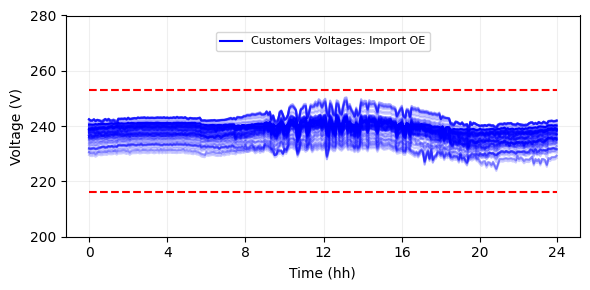

In [11]:
print('\n IMPORTS')
print('\n The minimum voltage at customers: {}V (Above the minimum voltage limit of 216V)'.format(round(np.min(valid_imp_voltage_lv_cust))))
print('\n The network-wide voltage compliance: {}% (Above the recommmended value of 95%)'.format(round(imp_voltage_compliance)))
print('\n The maximum utilisation of the distribution transformer: {}% (Below the maximum utilisation of 100%)'.format(round(np.max(valid_imp_lv_tx_util))))
print('\n The maximum utilisation of the LV Head of Feeder: {}% (Below the maximum utilisation of 100%)'.format(round(np.max(valid_imp_max_lv_hof_util))))

# plot the voltage at all customers
x = range(num_of_time_step)
y1 = valid_imp_voltage_lv_cust
y2 = np.ones(num_of_time_step) * 216
y3 = np.ones(num_of_time_step) * 253

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (hh)")
for ild in range(len(load_list)):
    if ild == 0:
        plt.plot(x, y1[ild,:], color="blue", alpha=1, label="Customers Voltages: Import OE")
    else:
        plt.plot(x, y1[ild,:], color="blue", alpha=0.2)
plt.plot(x, y2, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(200, 280)
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.815, 0, 0))
plt.tight_layout()
plt.show()

<span style="color:red">**<u>Note</u>.</span>** These metrics can be used to do comparisons with other OE implementations, but not all metrics used in the project are calculated here. For a complete performance analysis please refer to the final report of the project.